In [871]:
# defining and importing stuff
%matplotlib inline 
import numpy as np
import scipy as sc
from matplotlib import pylab as plt
from scipy.special import gamma
from scipy import integrate

In [872]:
# Approximates KL divergence for 1-D continuous p and q by using numerical integration. 
# Both p and q are continuous probability distributions over RV X. 
# We only know their values at sampled points x.
def kl1_cont(p,q,x):
    K = len(p)
    theProd = np.zeros(K)
    for k in range(0,K):
        if p[k] > 0.0:
            theProd[k] = p[k]*np.log(p[k]/q[k])
    return integrate.simps(theProd, x, dx=1, axis=-1, even='avg')


The following contains the tweakable parameters you can play with.  
1) The 'a' array contains the $\alpha$ values for the Dirichlet prior - determining the message from the Dirichlet towards the Polya.  
2) The 'pX' array contains the distribution over $X$ assumed to be passed back from beyond the Polya towards the Polya.  
Note: Don't tamper with 'ac' and 'capX', they are automatically generated normalisation constants dependent on the above. 


In [873]:

# approximates well
N = 11
pX = np.array([0.1, 0.9]) # distribution (incoming from right) p(X|Y=y)
#a = np.array([0.3, 0.7])  # distribution (incoming from left) p(theta;alpha)
a = np.array([0.7, 0.3])  # distribution (incoming from left) p(theta;alpha)

#pX = np.array([0.5, 0.5]) # distribution (incoming from right) p(X|Y=y)
#a = np.array([0.5, 0.5])  # distribution (incoming from left) p(theta;alpha)

a *= N

# normalisation, don't touch
ac = gamma(np.sum(a))/np.prod(gamma(a))
capX = pX.dot(a)/sum(a)


In [874]:
# sampling of the probs theta0 and theta1
q1 = np.linspace(5E-5,1.-5E-5,1000)
q0 = 1. - q1


For reference, lets first get the message originally sent by the Dirichlet cluster


area= 1.0000000057529022


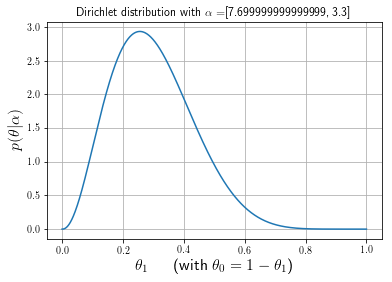

In [875]:
# the dirichlet distribution
f = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]-1.))

#check it via numerical integration
area = integrate.simps(f, q1, dx=1, axis=-1, even='avg')
print('area=',area)

# and plot it
plt.plot(q1,f)
plt.rc('text', usetex=True)
plt.xlabel(r'$\theta_1$ \hspace{5mm} (with $\theta_0 = 1-\theta_1$)',fontsize=16)
plt.ylabel(r'$p(\theta|\alpha)',
          fontsize=16)
plt.title(r'Dirichlet distribution with $\alpha=$[%s, %s]'%(a[0],a[1]))
plt.grid()
#plt.savefig('dirich.png')
plt.show()


In the following we determine what, ideally, the message returning from the Polya cluster towards the Dirichlet cluster should look like. That is the green curve in the graph below. It turn out to be a rather weird function, for instance with p0=0.9 it has a mode somewhere around theta1=0.25, then declines, and then rises sharply again with theta1 close to one. Weird.

area1P= 1.000000001707134
area2P= 1.0000000000000002


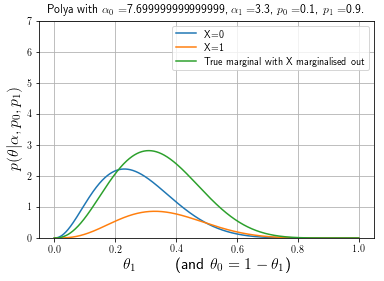

In [876]:
# the dirichlet distribution
f0 = ac*np.power(q0,a[0])*(np.power(q1,a[1]-1.))
f1 = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]))

# The *** true posterior marginal *** after we summed out X (p)
fP = (pX[0]*f0+pX[1]*f1)/capX

#check it via numerical integration
area = sc.integrate.simps(fP, q1, dx=1, axis=-1, even='avg')
print('area1P=',area)
fP = fP/area;
area = sc.integrate.simps(fP, q1, dx=1, axis=-1, even='avg')
print('area2P=',area)


# and plot it
x0,=plt.plot(q1,f0, label='X=0')
x1,=plt.plot(q1,f1, label='X=1')
x01,=plt.plot(q1,fP, label='True marginal with X marginalised out')
plt.rc('text', usetex=True)
plt.xlabel(r'$\theta_1$ \hspace{1cm} (and $\theta_0 = 1-\theta_1$)',fontsize=16)
plt.ylabel(r'$p(\theta|\alpha,p_0,p_1)$',
          fontsize=16)
plt.title(r'Polya with $\alpha_0=$%s, $\alpha_1=$%s, $p_0=$%s, $p_1=$%s.'%(a[0],a[1],pX[0],pX[1]))
plt.legend(handles=[x0, x1, x01])
plt.ylim((0,7))
plt.grid()
#plt.savefig('dirich.png')
plt.show()


Now we divide by the message that originally came from the Dirichlet cluster. This should give us the 'true' message to send from the Polya to the Dirichlet cluster. Interesting, why is it linear? It seems to have a simple form after all? It is not properly normalised though, and I doubt if it is directly expressible as a Dirichlet. 

area= 1.4704411739603482


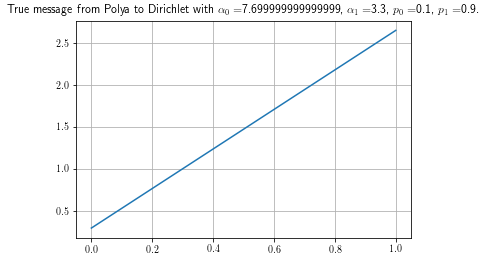

In [877]:
m_pd = fP/f

#check it via numerical integration
area = integrate.simps(m_pd, q1, dx=1, axis=-1, even='avg')
print('area=',area)

# and plot it
plt.plot(q1,m_pd)
plt.title(r'True message from Polya to Dirichlet with $\alpha_0=$%s, $\alpha_1=$%s, $p_0=$%s, $p_1=$%s.'%(a[0],a[1],pX[0],pX[1]))
plt.grid()
plt.show()


Below is the conclusions we reached about marginalising X out via sampling techniques. The important conclusion is right at the top of this code. The $\mathbf{\alpha}$'s passed backward to the Dirichlet works as follows:

1) First calculate the posterior $\mathbf{\alpha}$'s at the Polya node as:
\begin{align*}
\alpha'_k &= \frac{p_k\alpha_k}{\sum_j p_j\alpha_j} + \alpha_k.
\end{align*}

2) To get the message to send back to the Dirichlet, we first have to remove the original Dirichlet to get:
\begin{align*}
\alpha''_k &= \frac{p_k\alpha_k}{\sum_j p_j\alpha_j} + \alpha_k - \alpha_k.\\
           &= \frac{p_k\alpha_k}{\sum_j p_j\alpha_j}. 
\end{align*}

3) At the Dirichlet node, whatever its $\mathbf{\alpha}$'s are at that stage, will get added back to these $\mathbf{\alpha}$'s coming from the Polya.


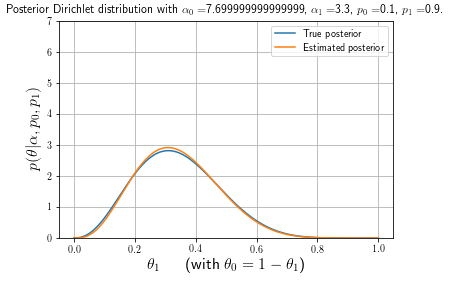

In [878]:
# now add the original alphas to get the posterior dirichlet alphas at the polya node

# you can use this to move the approximation left or right
da = 0.0 

# the alphas passed from the polya to the dirichlet, excluding the incoming dirichlet
aa = a*pX;
aa /= np.sum(aa) # renormalize since it is only one observation

aa += a

aa[0] += da
aa[1] -= da

#print('aa=',aa, ', sums to ', sum(aa))
caa = gamma(np.sum(aa))/np.prod(gamma(aa))

# *** the approximated posterior (q) **, before dividing out the incoming Dirichlet.
fQ = caa*np.power(q0,aa[0]+da-1.)*(np.power(q1,aa[1]-da-1.))
#check it via numerical integration
area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
#print('area1Q=',area)
fQ /= area;
area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
#print('area2Q=',area)

# and plot it
truePost,= plt.plot(q1,fP,label='True posterior')
estPost,= plt.plot(q1,fQ,label='Estimated posterior')
#oldPost,= plt.plot(q1,fold,label='Old posterior')

#plt.plot(q1,fP,q1,fsim)
plt.rc('text', usetex=True)
plt.xlabel(r'$\theta_1$ \hspace{5mm} (with $\theta_0 = 1-\theta_1$)',fontsize=16)
plt.ylabel(r'$p(\theta|\alpha,p_0,p_1)$',
          fontsize=16)
plt.title(r'Posterior Dirichlet distribution with $\alpha_0=$%s, $\alpha_1=$%s, $p_0=$%s, $p_1=$%s.'%(a[0],a[1],pX[0],pX[1]))
plt.legend(handles=[truePost, estPost])
plt.ylim((0,7))
plt.grid()
#plt.savefig('pdir.png')
plt.show()


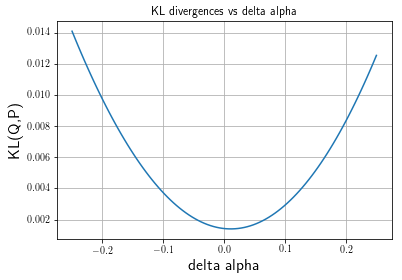

In [879]:
# now add the original alphas to get the posterior dirichlet alphas at the polya node
del_a = np.linspace(-0.25,0.25,100)
div = np.zeros(len(del_a))

for k in range( len(del_a) ):
  
  # the alphas passed from the polya to the dirichlet, excluding the incoming dirichlet
  aa = a*pX;
  aa /= np.sum(aa) # renormalize since it is only one observation

  aa += a

  aa[0] += del_a[k]
  aa[1] -= del_a[k]
  if aa[0] < 1E-9 or aa[1] < 1E-9:
        print("Oops, negative alphas! Reduce range on del_a!")
  #print('aa=',aa, ', sums to ', sum(aa))
  caa = gamma(np.sum(aa))/np.prod(gamma(aa))

  # *** the approximated posterior (q) **, before dividing out the incoming Dirichlet.
  fQ = caa*np.power(q0,aa[0]+da-1.)*(np.power(q1,aa[1]-da-1.))
  #check it via numerical integration
  area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
  #print('area1Q=',area)
  fQ /= area; #renormalize for the sake of simpson's rule
  area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
  #print('area2Q=',area)

  div[k] = kl1_cont(fQ,fP,q1)

plt.plot(del_a,div,label='KL divergences vs delta alpha')    
plt.xlabel('delta alpha',fontsize=16)
plt.ylabel('KL(Q,P)',
          fontsize=16)
plt.title('KL divergences vs delta alpha')
plt.grid()
plt.show()

